<a href="https://colab.research.google.com/github/mountagalam/lam/blob/master/PINNs_Equation_Burgers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install deepxde

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.7/190.7 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 8.1 MB/s eta 0:00:00


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving burgers_shock.mat to burgers_shock.mat


In [ ]:
import os
os.listdir('/content/')  # Lists all files in /content/

['.config', 'burgers_shock.mat', 'sample_data']

In [ ]:
#Telecharger la reference solution pour comparaison
import scipy.io

dataset_Burgers = scipy.io.loadmat('burgers_shock.mat')

In [ ]:
dataset_Burgers

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Wed Sep 20 16:38:22 2017',
 '__version__': '1.0',
 '__globals__': [],
 'x': array([[-1.        ],
        [-0.99215686],
        [-0.98431373],
        [-0.97647059],
        [-0.96862745],
        [-0.96078431],
        [-0.95294118],
        [-0.94509804],
        [-0.9372549 ],
        [-0.92941176],
        [-0.92156863],
        [-0.91372549],
        [-0.90588235],
        [-0.89803922],
        [-0.89019608],
        [-0.88235294],
        [-0.8745098 ],
        [-0.86666667],
        [-0.85882353],
        [-0.85098039],
        [-0.84313725],
        [-0.83529412],
        [-0.82745098],
        [-0.81960784],
        [-0.81176471],
        [-0.80392157],
        [-0.79607843],
        [-0.78823529],
        [-0.78039216],
        [-0.77254902],
        [-0.76470588],
        [-0.75686275],
        [-0.74901961],
        [-0.74117647],
        [-0.73333333],
        [-0.7254902 ],
        [-0.71764706],
        

In [ ]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
import time


No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


In [ ]:
# Définir le chemin du dossier de sauvegarde sur le bureau
#save_path = "C:/Users/Aissatou/Desktop/Burgers_Results"

# Créer le dossier s'il n'existe pas
#os.makedirs(save_path, exist_ok=True)


Compiling model...
Building feed-forward neural network...
'build' took 0.169501 s

'compile' took 1.083809 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [3.32e-02, 3.49e-02, 3.92e-01]    [3.32e-02, 3.49e-02, 3.92e-01]    []  
1000      [1.50e-02, 3.23e-04, 2.44e-02]    [1.50e-02, 3.23e-04, 2.44e-02]    []  
2000      [3.03e-03, 1.20e-04, 1.85e-03]    [3.03e-03, 1.20e-04, 1.85e-03]    []  
3000      [1.40e-03, 3.84e-05, 6.93e-04]    [1.40e-03, 3.84e-05, 6.93e-04]    []  
4000      [5.53e-04, 8.17e-06, 3.47e-04]    [5.53e-04, 8.17e-06, 3.47e-04]    []  
5000      [9.45e-04, 5.90e-05, 1.90e-04]    [9.45e-04, 5.90e-05, 1.90e-04]    []  
6000      [4.69e-04, 1.08e-04, 1.29e-04]    [4.69e-04, 1.08e-04, 1.29e-04]    []  
7000      [2.30e-04, 3.27e-06, 9.64e-05]    [2.30e-04, 3.27e-06, 9.64e-05]    []  
8000      [1.64e-04, 2.17e-06, 5.77e-05]    [1.64e-04, 2.17e-06, 5.77e-05]    []  
9000      [1.92e-04, 1.52e-05, 5.

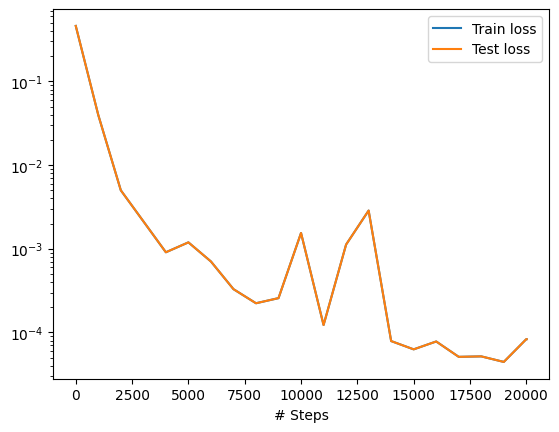

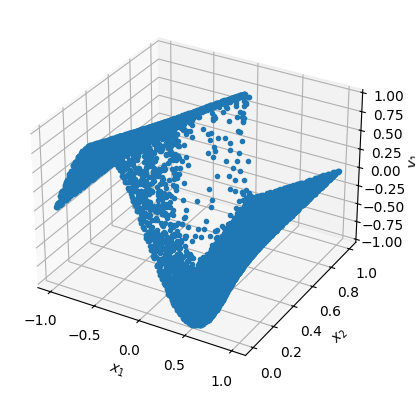

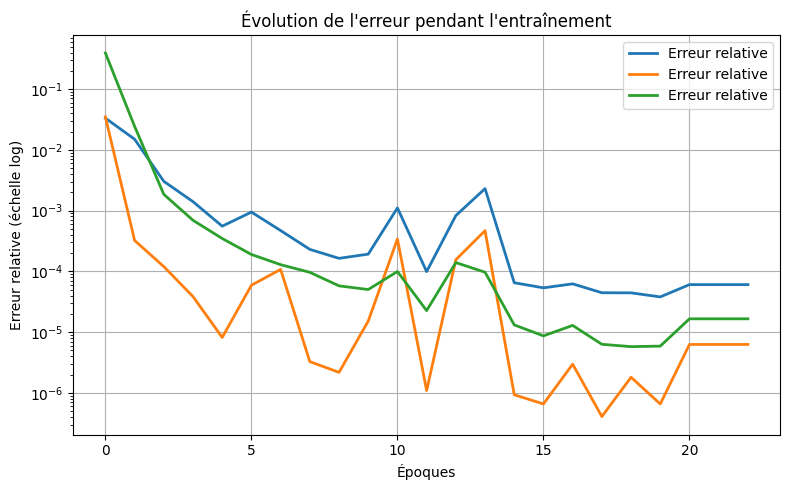

Erreur relative globale : 1.213525e-02


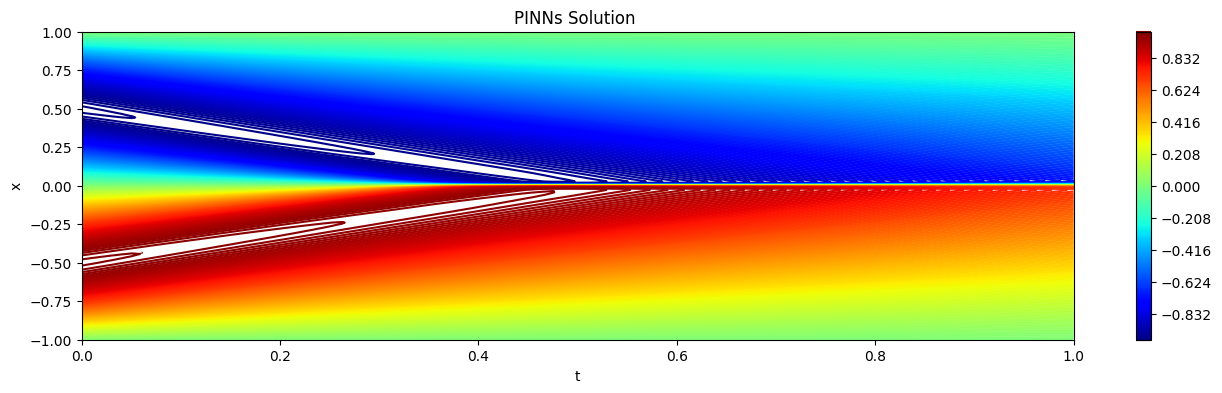

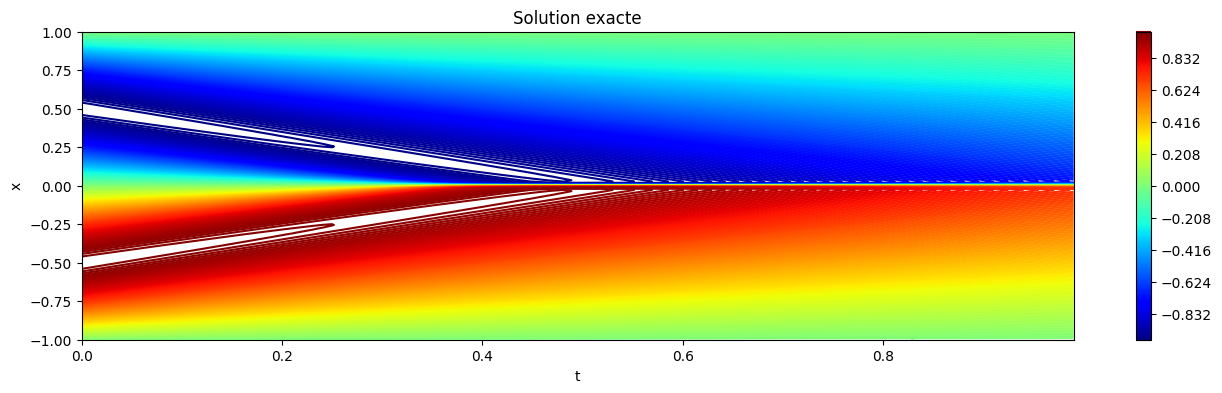

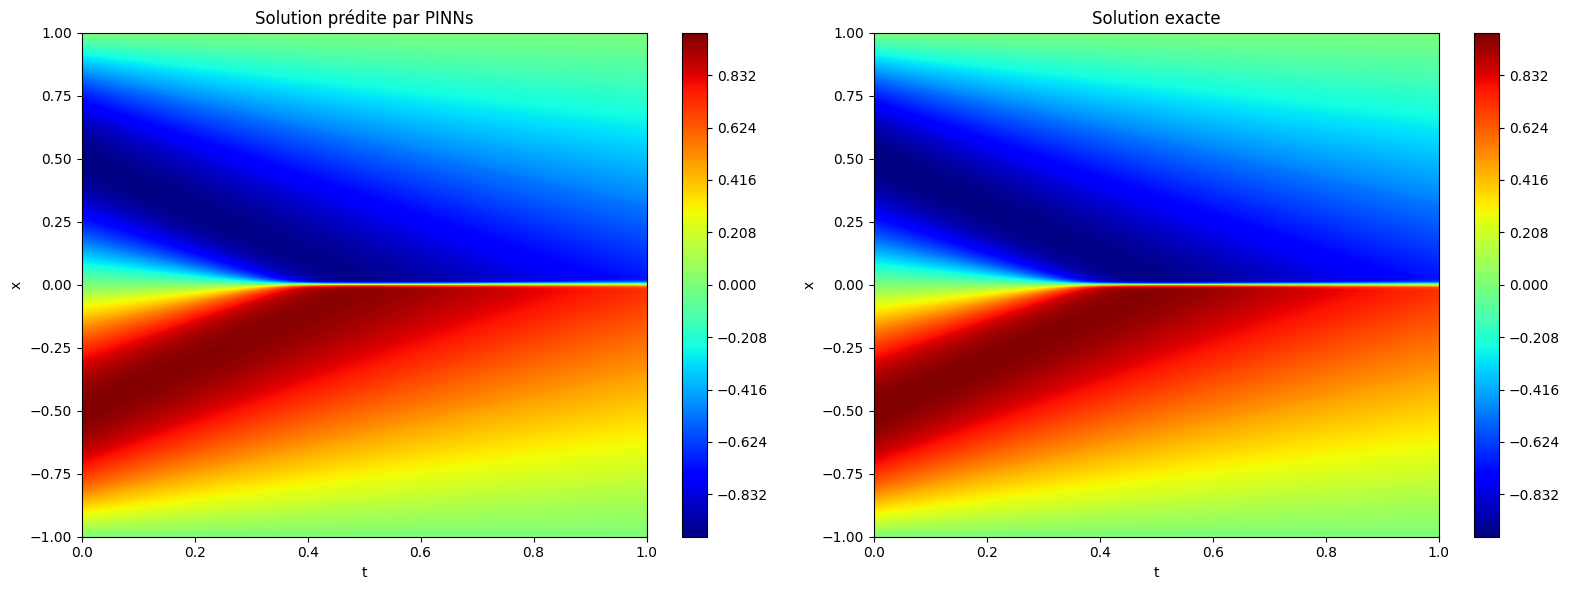

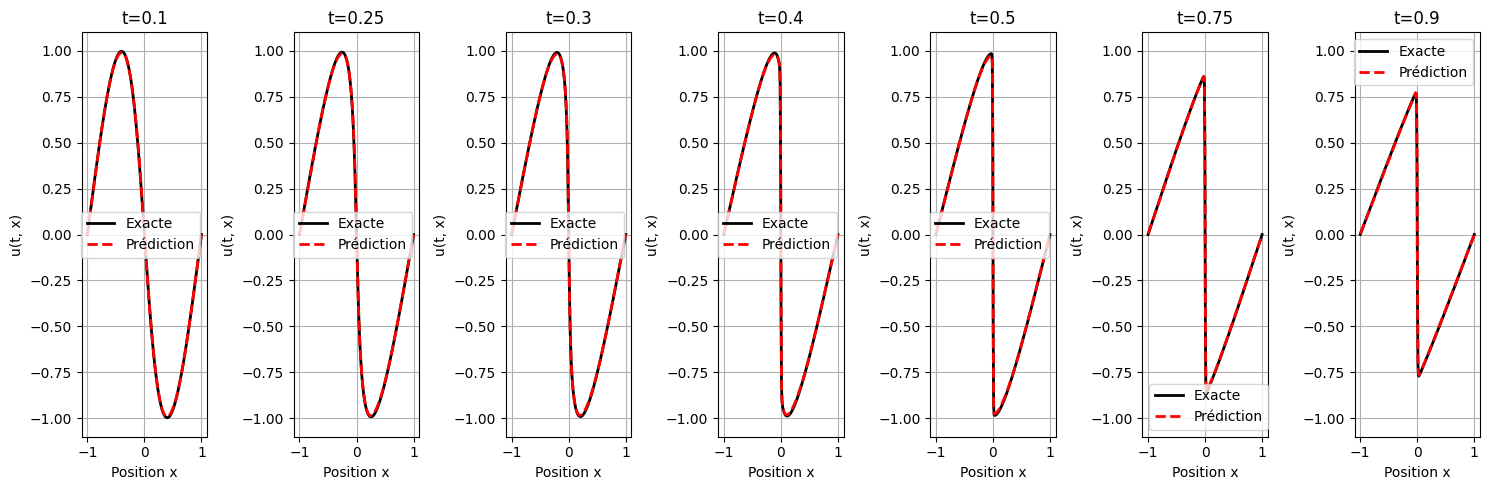

In [ ]:
# CAS NON AUTONOME


# ==============================================
# CHARGEMENT DE LA SOLUTION EXACTE DE L'ÉQUATION DE BURGERS
# ==============================================
# On suppose que dataset_Burgers contient la solution exacte issue d'une méthode de référence

x_ref, t_ref, exact_Burgers = dataset_Burgers["x"], dataset_Burgers["t"], dataset_Burgers["usol"].T

# Création d'une grille pour les variables spatiales et temporelles
x_ref, t_ref = np.meshgrid(x_ref, t_ref)


# ==============================================
# PARAMÈTRES DU PROBLÈME (ALIGNÉS AVEC MVF)
# ==============================================
L = 1.0            # Domaine spatial : x ∈ [-1, 1]
nu = 0.01 / np.pi  # Coefficient de viscosité pour l'équation de Burgers
nx = 256           # Résolution spatiale (comme MVF)
nt = 100           # Résolution temporelle (comme MVF)


# ==============================================
# DÉFINIR L'ÉQUATION DIFFÉRENTIELLE PARTIELLE (EDP)
# ==============================================
def burgers_pde(x, u):
    """ Définit l'équation de Burgers : u_t + u * u_x - nu * u_xx = 0 """
    du_t = dde.grad.jacobian(u, x, i=0, j=1)  # Dérivée temporelle
    du_x = dde.grad.jacobian(u, x, i=0, j=0)  # Dérivée spatiale
    du_xx = dde.grad.hessian(u, x, i=0, j=0)  # Dérivée seconde spatiale
    return du_t + u * du_x - nu * du_xx


# ==============================================
# DÉFINIR LE DOMAINE ESPACE-TEMPS
# ==============================================
spatial_domain = dde.geometry.Interval(-L, L)  # Domaine spatial
temporal_domain = dde.geometry.TimeDomain(0, 1)  # Domaine temporel
domain = dde.geometry.GeometryXTime(spatial_domain, temporal_domain)  # Domaine espace-temps


# ==============================================
# CONDITIONS INITIALES ET AUX LIMITES
# ==============================================
# Condition initiale : u(0, x) = -sin(pi * x)
def initial_function(x):
    """ Fonction initiale définie comme u(0, x) = -sin(pi * x) """
    return -np.sin(np.pi * x[:, 0:1])

initial_condition = dde.icbc.IC(
    domain, initial_function, lambda _, on_initial: on_initial
)

# Condition aux limites : u(t, -1) = u(t, 1) = 0
def boundary_function(x):
    """ Fonction définissant les conditions aux limites : u(t, -1) = u(t, 1) = 0 """
    return 0

boundary_condition = dde.icbc.DirichletBC(
    domain, boundary_function, lambda x, on_boundary: on_boundary
)


# ==============================================
# PRÉPARATION DES DONNÉES
# ==============================================
data = dde.data.TimePDE(
    domain,
    burgers_pde,
    [boundary_condition, initial_condition],
    num_domain=10000,  # Points dans le domaine espace-temps
    num_boundary=100,  # Points sur la frontière
    num_initial=100,   # Points pour les conditions initiales
    train_distribution="LHS",  # Distribution Latin Hypercube pour une meilleure couverture
)


# ==============================================
# CONFIGURATION DU RÉSEAU DE NEURONES
# ==============================================
net = dde.maps.FNN(
    [2] + [20] * 9 + [1],               # Architecture : 9 couches avec 20 neurones chacune
    activation="tanh",                  # Fonction d'activation hyperbolique tangente  pour une meilleure approximation des solutions continues
    kernel_initializer="Glorot normal"  # Initialisation des poids
)


# ==============================================
# CONFIGURATION ET ENTRAÎNEMENT DU MODÈLE
# ==============================================
model = dde.Model(data, net)



# Étape 1 : Entraînement avec Adam
start_time_adam = time.time()
model.compile("adam", lr=1e-3)                        # Optimiseur Adam avec un taux d'apprentissage de 0.001
model.train(iterations=20000)                         # Entraînement sur 20 000 itérations
end_time_adam = time.time()


# Étape 2 : Raffinement avec L-BFGS-B
start_time_lbfgs = time.time()
model.compile("L-BFGS-B")  # Optimiseur L-BFGS-B pour le raffinement
losshistory, train_state = model.train()
end_time_lbfgs = time.time()

time_adam = end_time_adam - start_time_adam
time_lbfgs = end_time_lbfgs - start_time_lbfgs

print(f"Temps d'entraînement avec Adam : {time_adam:.2f} secondes")
print(f"Temps d'affinage avec L-BFGS-B : {time_lbfgs:.2f} secondes")

total_time = time_adam + time_lbfgs
print(f"Temps total d'entraînement : {total_time:.2f} secondes")


# Sauvegarde des résultats
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

# ==============================================
# Courbe de perte
# ==============================================
#dde.utils.plot_loss_history(losshistory)
#plt.savefig("loss_history.png")
#plt.show()


# ==============================================
# TRAÇAGE DE L'ÉVOLUTION DE L'ERREUR RELATIVE
# ==============================================
loss_train = losshistory.loss_train
iterations = range(len(loss_train))

plt.figure(figsize=(8, 5))
plt.plot(iterations, loss_train, label="Erreur relative", linewidth=2)
plt.yscale("log")
plt.xlabel("Époques")
plt.ylabel("Erreur relative (échelle log)")
plt.title("Évolution de l'erreur pendant l'entraînement")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("relative_error_evolution.png")
plt.show()

plt.close()

# ==============================================
# ÉVALUATION DU MODÈLE
# ==============================================
x_test = np.linspace(-L, L, nx)  # Domaine spatial pour l'évaluation
t_test = np.linspace(0, 1, nt)   # Domaine temporel pour l'évaluation
X, T = np.meshgrid(x_test, t_test)
X_flat = X.flatten()[:, None]
T_flat = T.flatten()[:, None]
XT = np.hstack((X_flat, T_flat))


# Prédiction de la solution
PINNs_Burgers = model.predict(XT).reshape(X.shape)

# Calcul de l'erreur relative globale
erreur_relative = np.linalg.norm(PINNs_Burgers - exact_Burgers) / np.linalg.norm(exact_Burgers)
print(f"Erreur relative globale : {erreur_relative:.6e}")

# Tracer la solution PINNs

plt.figure(figsize = (16, 4))
plt.contour(T, X, PINNs_Burgers, levels=250, cmap = 'jet')
plt.colorbar()
plt.xlabel('t')
plt.ylabel('x')
plt.title('PINNs Solution ')
plt.show()
plt.savefig("PINNs_Solution.png")
plt.close()

# Tracer la solution de reference

plt.figure(figsize = (16, 4))
plt.contour(t_ref, x_ref, exact_Burgers, levels=250, cmap = 'jet')
plt.colorbar()
plt.xlabel('t')
plt.ylabel('x')
plt.title('Solution exacte')
plt.show()
plt.savefig("Exact_Solution.png")
plt.close()


# ==============================================
# VISUALISATION DES RÉSULTATS
# ==============================================
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
c1 = axs[0].contourf(T, X, PINNs_Burgers, levels=250, cmap="jet")
plt.colorbar(c1, ax=axs[0])
axs[0].set_title("Solution prédite par PINNs")
axs[0].set_xlabel("t")
axs[0].set_ylabel("x")


c2 = axs[1].contourf(T, X, exact_Burgers, levels=250, cmap="jet")
plt.colorbar(c2, ax=axs[1])
axs[1].set_title("Solution exacte")
axs[1].set_xlabel("t")
axs[1].set_ylabel("x")

plt.tight_layout()
plt.savefig("solution_comparison_{time_elapsed:.2f}s.png")
plt.show()

plt.close()
# ==============================================
# COMPARAISON DES COUPES TEMPORELLES
# ==============================================
time_slices = [0.10, 0.25, 0.30, 0.40, 0.50, 0.75, 0.90]
fig, axs = plt.subplots(1, len(time_slices), figsize=(15, 5))

for i, t in enumerate(time_slices):
    idx = np.abs(t_test - t).argmin()  # Trouver l'indice correspondant à t
    axs[i].plot(x_test, exact_Burgers[idx, :], label=f"Exacte", linewidth=2, color="black")
    axs[i].plot(x_test, PINNs_Burgers[idx, :], "--", label=f"Prédiction", linewidth=2, color="red")
    axs[i].set_title(f"t={t}")
    axs[i].set_xlabel("Position x")
    axs[i].set_ylabel("u(t, x)")
    axs[i].legend()
    axs[i].grid(True)
    axs[i].set_ylim(-1.1, 1.1)

plt.tight_layout()
plt.savefig("temporal_slices_{time_elapsed:.2f}s.png")
plt.show()

plt.close()




In [ ]:

import pandas as pd


# ==============================================
# CALCUL ET SAUVEGARDE DE L'ERREUR RELATIVE PAR TEMPS POUR LA SOLUTION PINNs
# ==============================================
def erreur_relative(u_num, u_exact):
    return np.linalg.norm(u_num - u_exact) / np.linalg.norm(u_exact)

erreurs_PINNs = {
    "Temps": t_test,
    "Erreur_PINNs": [erreur_relative(PINNs_Burgers[n, :], exact_Burgers[n, :]) for n in range(nt)]
}

csv_path = os.path.join( "erreurs_PINNs.csv")
pd.DataFrame(erreurs_PINNs).to_csv(csv_path, index=False)

# Affichage des 10 premières lignes du fichier CSV pour vérification
erreurs_df = pd.read_csv(csv_path)
print(erreurs_df.head(50))


       Temps  Erreur_PINNs
0   0.000000      0.005600
1   0.010101      0.005499
2   0.020202      0.005452
3   0.030303      0.005449
4   0.040404      0.005484
5   0.050505      0.005550
6   0.060606      0.005644
7   0.070707      0.005761
8   0.080808      0.005897
9   0.090909      0.006049
10  0.101010      0.006211
11  0.111111      0.006382
12  0.121212      0.006556
13  0.131313      0.006730
14  0.141414      0.006902
15  0.151515      0.007069
16  0.161616      0.007228
17  0.171717      0.007379
18  0.181818      0.007519
19  0.191919      0.007648
20  0.202020      0.007765
21  0.212121      0.007873
22  0.222222      0.007970
23  0.232323      0.008058
24  0.242424      0.008138
25  0.252525      0.008209
26  0.262626      0.008268
27  0.272727      0.008308
28  0.282828      0.008318
29  0.292929      0.008283
30  0.303030      0.008183
31  0.313131      0.007997
32  0.323232      0.007711
33  0.333333      0.007333
34  0.343434      0.006902
35  0.353535      0.006485
3

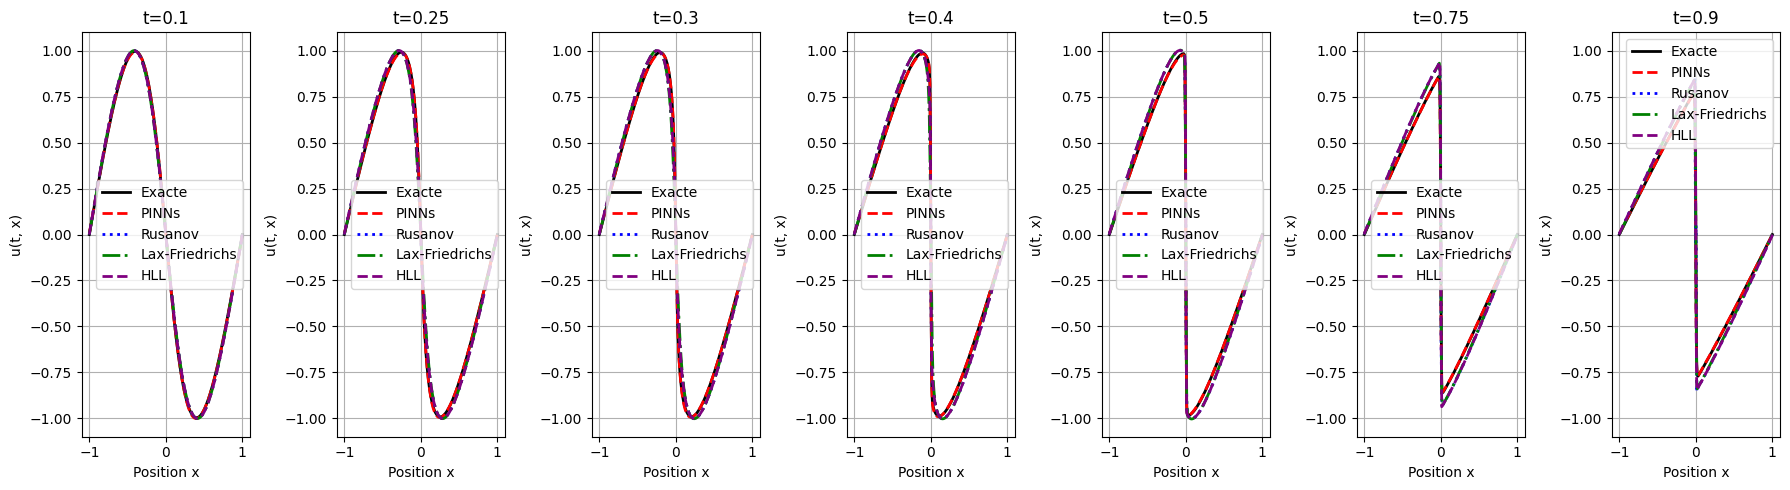

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import deepxde as dde
import time

# ==============================================
# CHARGEMENT DES DONNÉES DE LA SOLUTION EXACTE
# ==============================================
# On suppose que dataset_Burgers contient la solution exacte issue d'une méthode de référence
x_ref, t_ref, exact_Burgers = dataset_Burgers["x"], dataset_Burgers["t"], dataset_Burgers["usol"].T
x_ref, t_ref = np.meshgrid(x_ref, t_ref)

# ==============================================
# PARAMÈTRES DU PROBLÈME (ALIGNÉS AVEC MVF)
# ==============================================
L = 1.0  # Domaine spatial : x ∈ [-1, 1]
nu = 0.01 / np.pi  # Coefficient de viscosité
nx = 256  # Résolution spatiale
nt = 100  # Résolution temporelle
cfl = 1.1

x_test = np.linspace(-L, L, nx)
t_test = np.linspace(0, 1, nt)
dx = x_test[1] - x_test[0]
# ==============================================
# CHARGEMENT DES SOLUTIONS DES SCHÉMAS NUMÉRIQUES
# ==============================================

# Fonctions de flux
def flux(u):
    return 0.5 * u**2

def rusanov_flux(u_L, u_R):
    f_L, f_R = flux(u_L), flux(u_R)
    lambda_max = max(abs(u_L), abs(u_R))
    return 0.5 * (f_L + f_R) - 0.5 * lambda_max * (u_R - u_L)

def hll_flux(u_L, u_R):
    s_L, s_R = min(u_L, u_R), max(u_L, u_R)
    if s_L > 0:
        return flux(u_L)
    elif s_R < 0:
        return flux(u_R)
    else:
        return (s_R * flux(u_L) - s_L * flux(u_R) + s_L * s_R * (u_R - u_L)) / (s_R - s_L + 1e-6)

# Initialisation des solutions numériques
u_lax, u_rusanov, u_hll = np.zeros((nt, nx)), np.zeros((nt, nx)), np.zeros((nt, nx))
u_init = -np.sin(np.pi * x_test)
u_lax[0, :], u_rusanov[0, :], u_hll[0, :] = u_init, u_init, u_init

# Boucle temporelle
for n in range(1, nt):
    u_new_lax, u_new_rusanov, u_new_hll = np.zeros(nx), np.zeros(nx), np.zeros(nx)

    umax = max(np.max(np.abs(u_lax[n - 1, :])), np.max(np.abs(u_rusanov[n - 1, :])), np.max(np.abs(u_hll[n - 1, :])))
    dt = cfl * dx / (umax)

    for i in range(1, nx - 1):
        # Lax-Friedrichs
        u_new_lax[i] = 0.5 * (u_lax[n - 1, i + 1] + u_lax[n - 1, i - 1]) - (dt / (2 * dx)) * (flux(u_lax[n - 1, i + 1]) - flux(u_lax[n - 1, i - 1]))

        # Rusanov
        F_plus = rusanov_flux(u_rusanov[n - 1, i], u_rusanov[n - 1, i + 1])
        F_minus = rusanov_flux(u_rusanov[n - 1, i - 1], u_rusanov[n - 1, i])
        u_new_rusanov[i] = u_rusanov[n - 1, i] - (dt / dx) * (F_plus - F_minus)

        # HLL
        u_new_hll[i] = u_hll[n - 1, i] - (dt / dx) * (hll_flux(u_hll[n - 1, i], u_hll[n - 1, i + 1]) - hll_flux(u_hll[n - 1, i - 1], u_hll[n - 1, i]))

    # Conditions aux limites (Dirichlet)
    u_new_lax[0] = u_new_lax[-1] = 0
    u_new_rusanov[0] = u_new_rusanov[-1] = 0
    u_new_hll[0] = u_new_hll[-1] = 0

    # Mise à jour des solutions
    u_lax[n, :], u_rusanov[n, :], u_hll[n, :] = u_new_lax, u_new_rusanov, u_new_hll



# ==============================================
# CHARGEMENT DE LA SOLUTION PINNs
# ==============================================
X, T = np.meshgrid(x_test, t_test)
X_flat = X.flatten()[:, None]
T_flat = T.flatten()[:, None]
XT = np.hstack((X_flat, T_flat))

# Prédiction de la solution PINNs
PINNs_Burgers = model.predict(XT).reshape(X.shape)

# ==============================================
# AFFICHAGE DES RÉSULTATS COMPARÉS
# ==============================================
time_slices = [0.10, 0.25, 0.30, 0.40, 0.50, 0.75, 0.90]
fig, axs = plt.subplots(1, len(time_slices), figsize=(18, 5))

for i, t in enumerate(time_slices):
    idx = np.abs(t_test - t).argmin()  # Trouver l'indice correspondant à t

    axs[i].plot(x_test, exact_Burgers[idx, :], label="Exacte", linewidth=2, color="black")
    axs[i].plot(x_test, PINNs_Burgers[idx, :], "--", label="PINNs", linewidth=2, color="red")
    axs[i].plot(x_test, u_rusanov[idx, :], ":", label="Rusanov", linewidth=2, color="blue")
    axs[i].plot(x_test, u_lax[idx, :], "-.", label="Lax-Friedrichs", linewidth=2, color="green")
    axs[i].plot(x_test, u_hll[idx, :], "--", label="HLL", linewidth=2, color="purple")

    axs[i].set_title(f"t={t}")
    axs[i].set_xlabel("Position x")
    axs[i].set_ylabel("u(t, x)")
    axs[i].legend()
    axs[i].grid(True)
    axs[i].set_ylim(-1.1, 1.1)

plt.tight_layout()
plt.savefig("comparison_slices.png")
plt.show()


Compiling model...
Building feed-forward neural network...
'build' took 0.147769 s

'compile' took 1.089620 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [3.52e-01, 4.35e-01, 1.39e+00]    [3.52e-01, 4.35e-01, 1.39e+00]    []  
1000      [3.81e-02, 1.50e-03, 5.80e-02]    [3.81e-02, 1.50e-03, 5.80e-02]    []  
2000      [3.06e-02, 3.85e-04, 5.30e-02]    [3.06e-02, 3.85e-04, 5.30e-02]    []  
3000      [3.70e-02, 1.48e-04, 5.56e-02]    [3.70e-02, 1.48e-04, 5.56e-02]    []  
4000      [8.02e-02, 5.47e-04, 9.70e-02]    [8.02e-02, 5.47e-04, 9.70e-02]    []  
5000      [2.91e-02, 8.06e-05, 5.79e-02]    [2.91e-02, 8.06e-05, 5.79e-02]    []  
6000      [3.17e-02, 1.10e-04, 5.61e-02]    [3.17e-02, 1.10e-04, 5.61e-02]    []  
7000      [2.73e-02, 2.06e-05, 5.23e-02]    [2.73e-02, 2.06e-05, 5.23e-02]    []  
8000      [2.67e-02, 8.59e-06, 5.17e-02]    [2.67e-02, 8.59e-06, 5.17e-02]    []  
9000      [2.79e-02, 1.20e-05, 5.

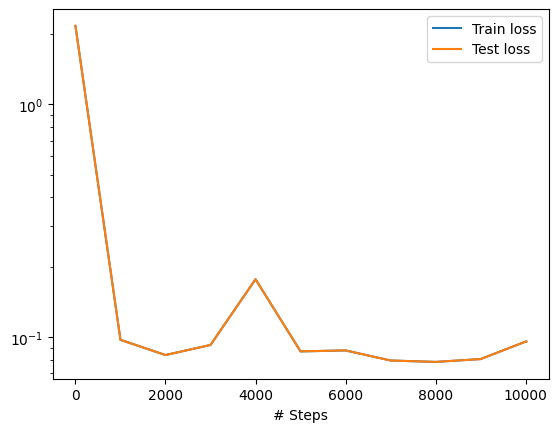

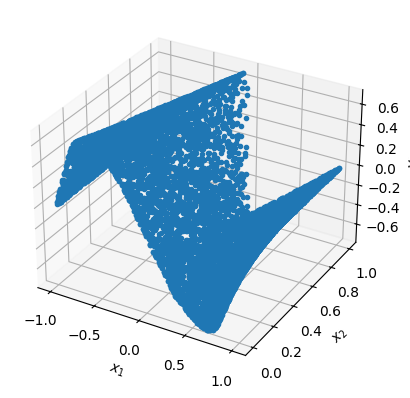

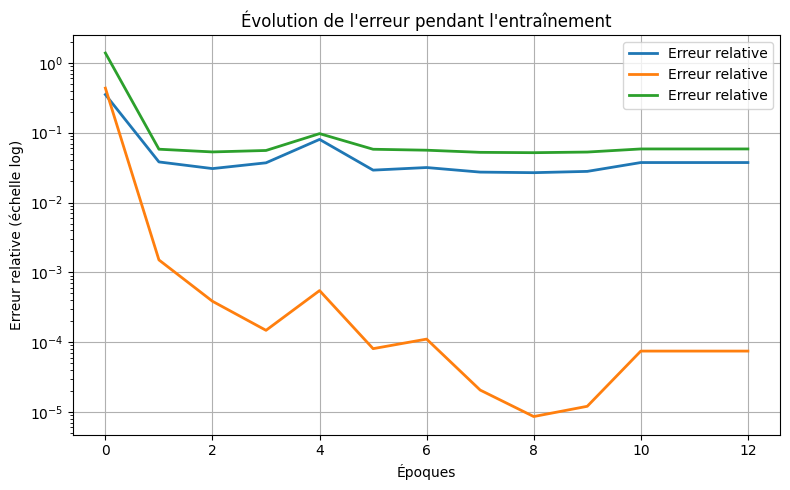

Erreur relative globale : 4.718956e-01


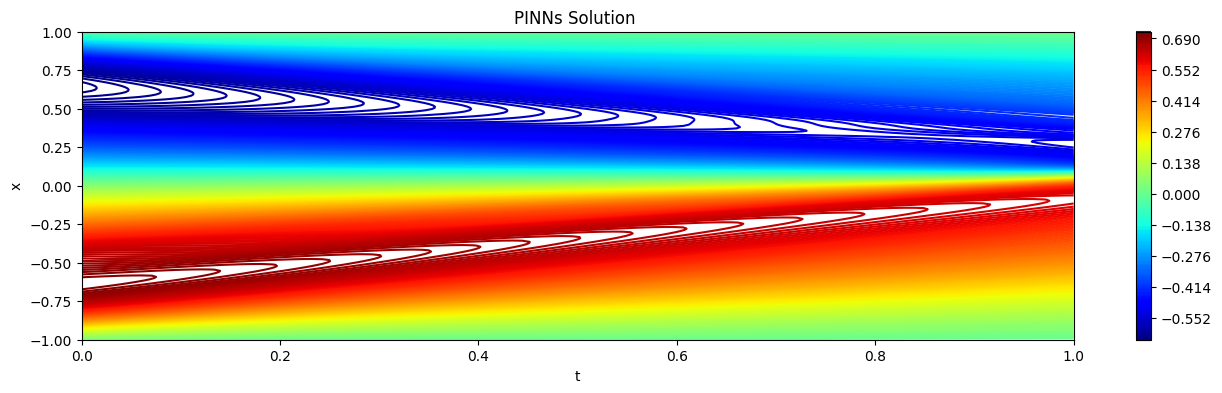

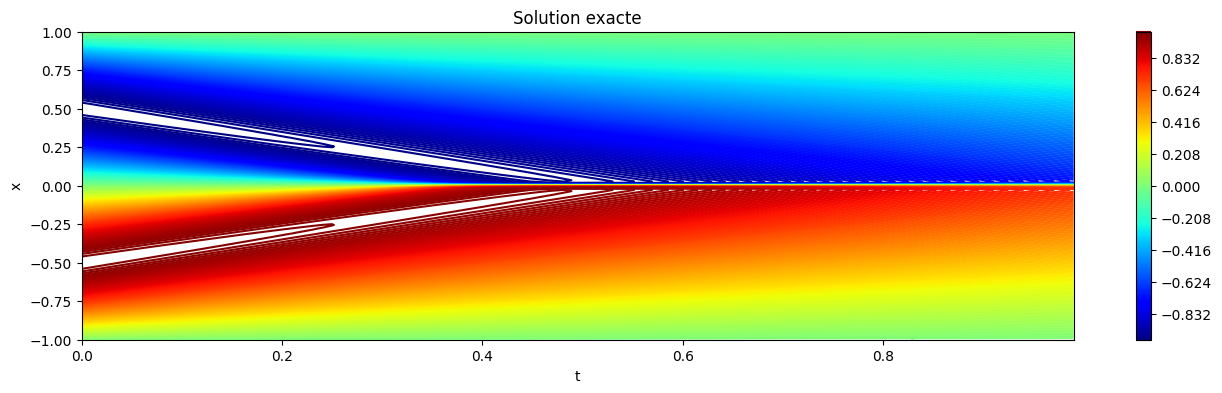

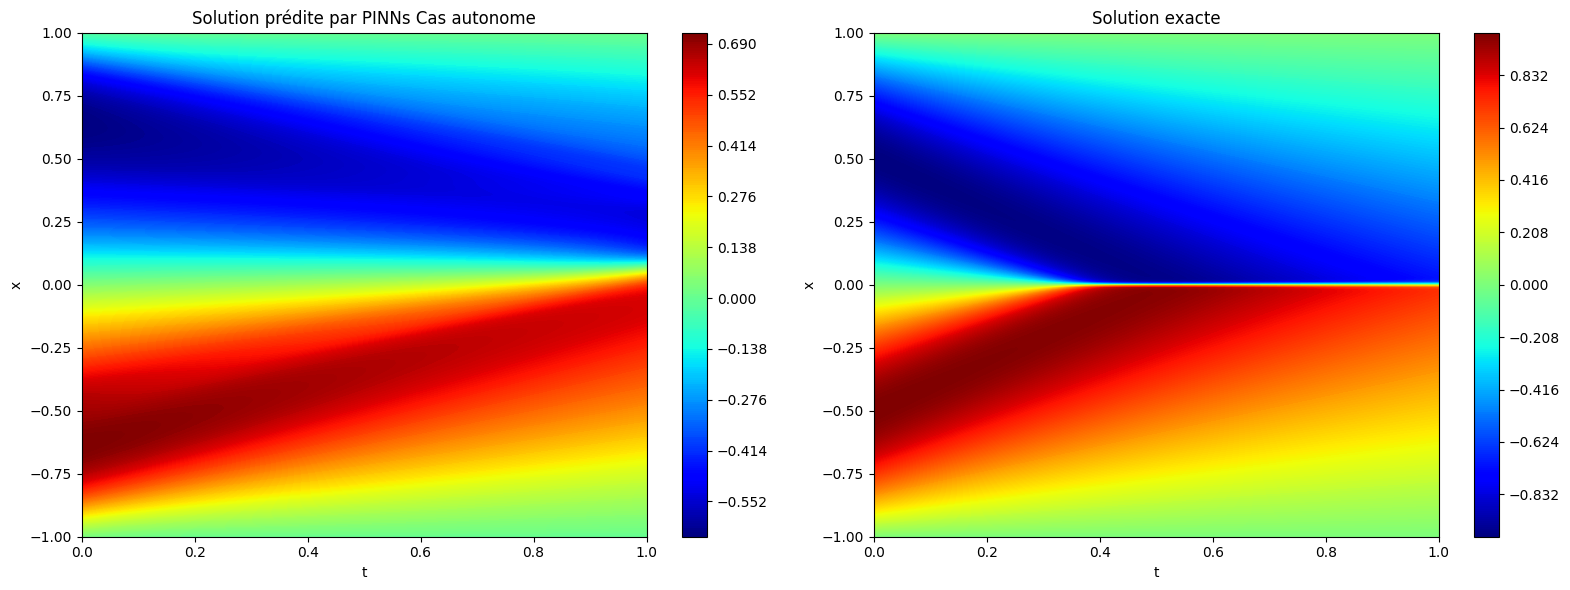

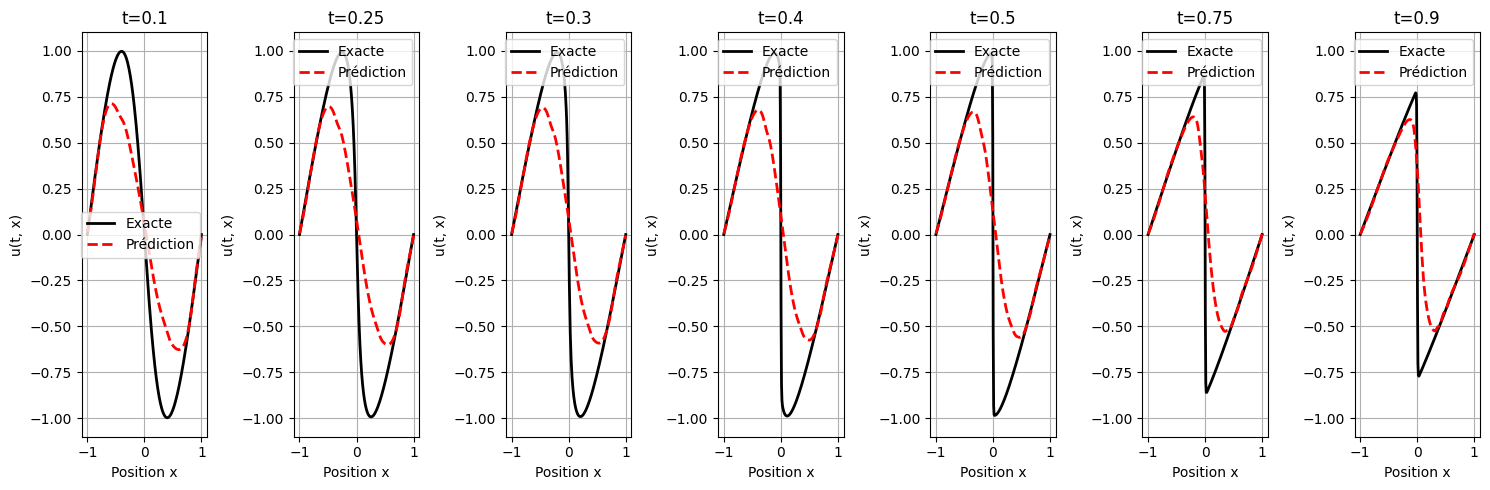

In [ ]:
#CAS AUTONOME


# ==============================================
# CHARGEMENT DE LA SOLUTION EXACTE DE L'ÉQUATION DE BURGERS
# ==============================================
# On suppose que dataset_Burgers contient la solution exacte issue d'une méthode de référence

x_ref, t_ref, exact_Burgers = dataset_Burgers["x"], dataset_Burgers["t"], dataset_Burgers["usol"].T

# Création d'une grille pour les variables spatiales et temporelles
x_ref, t_ref = np.meshgrid(x_ref, t_ref)


# ==============================================
# PARAMÈTRES DU PROBLÈME (ALIGNÉS AVEC MVF)
# ==============================================
L = 1.0            # Domaine spatial : x ∈ [-1, 1]
nu = 0.0           # Coefficient de viscosité pour l'équation de Burgers
nx = 256           # Résolution spatiale (comme MVF)
nt = 100           # Résolution temporelle (comme MVF)


# ==============================================
# DÉFINIR L'ÉQUATION DIFFÉRENTIELLE PARTIELLE (EDP)
# ==============================================
def burgers_pde(x, u):
    """ Définit l'équation de Burgers : u_t + u * u_x - nu * u_xx = 0 """
    du_t = dde.grad.jacobian(u, x, i=0, j=1)  # Dérivée temporelle
    du_x = dde.grad.jacobian(u, x, i=0, j=0)  # Dérivée spatiale
    du_xx = dde.grad.hessian(u, x, i=0, j=0)  # Dérivée seconde spatiale
    return du_t + u * du_x - nu * du_xx


# ==============================================
# DÉFINIR LE DOMAINE ESPACE-TEMPS
# ==============================================
spatial_domain = dde.geometry.Interval(-L, L)  # Domaine spatial
temporal_domain = dde.geometry.TimeDomain(0, 1)  # Domaine temporel
domain = dde.geometry.GeometryXTime(spatial_domain, temporal_domain)  # Domaine espace-temps


# ==============================================
# CONDITIONS INITIALES ET AUX LIMITES
# ==============================================
# Condition initiale : u(0, x) = -sin(pi * x)
def initial_function(x):
    """ Fonction initiale définie comme u(0, x) = -sin(pi * x) """
    return -np.sin(np.pi * x[:, 0:1])

initial_condition = dde.icbc.IC(
    domain, initial_function, lambda _, on_initial: on_initial
)

# Condition aux limites : u(t, -1) = u(t, 1) = 0
def boundary_function(x):
    """ Fonction définissant les conditions aux limites : u(t, -1) = u(t, 1) = 0 """
    return 0

boundary_condition = dde.icbc.DirichletBC(
    domain, boundary_function, lambda x, on_boundary: on_boundary
)


# ==============================================
# PRÉPARATION DES DONNÉES
# ==============================================
data = dde.data.TimePDE(
    domain,
    burgers_pde,
    [boundary_condition, initial_condition],
    num_domain=10000,  # Points dans le domaine espace-temps
    num_boundary=100,  # Points sur la frontière
    num_initial=100,   # Points pour les conditions initiales
    train_distribution="LHS",  # Distribution Latin Hypercube pour une meilleure couverture
)


# ==============================================
# CONFIGURATION DU RÉSEAU DE NEURONES
# ==============================================
net = dde.maps.FNN(
    [2] + [20] * 9 + [1],               # Architecture : 9 couches avec 20 neurones chacune
    activation="tanh",                  # Fonction d'activation hyperbolique tangente  pour une meilleure approximation des solutions continues
    kernel_initializer="Glorot normal"  # Initialisation des poids
)


# ==============================================
# CONFIGURATION ET ENTRAÎNEMENT DU MODÈLE
# ==============================================
model = dde.Model(data, net)



# Étape 1 : Entraînement avec Adam
start_time_adam = time.time()
model.compile("adam", lr=1e-3)                        # Optimiseur Adam avec un taux d'apprentissage de 0.001
model.train(iterations=10000)                         # Entraînement sur 10 000 itérations
end_time_adam = time.time()


# Étape 2 : Raffinement avec L-BFGS-B
start_time_lbfgs = time.time()
model.compile("L-BFGS-B")  # Optimiseur L-BFGS-B pour le raffinement
losshistory, train_state = model.train()
end_time_lbfgs = time.time()

time_adam = end_time_adam - start_time_adam
time_lbfgs = end_time_lbfgs - start_time_lbfgs

print(f"Temps d'entraînement avec Adam : {time_adam:.2f} secondes")
print(f"Temps d'affinage avec L-BFGS-B : {time_lbfgs:.2f} secondes")

total_time = time_adam + time_lbfgs
print(f"Temps total d'entraînement : {total_time:.2f} secondes")

# Sauvegarde des résultats
dde.saveplot(losshistory, train_state, issave=True, isplot=True)


# ==============================================
# Courbe de perte
# ==============================================
#dde.utils.plot_loss_history(losshistory)
#plt.savefig("loss_history.png")
#plt.show()


# ==============================================
# TRAÇAGE DE L'ÉVOLUTION DE L'ERREUR RELATIVE
# ==============================================
loss_train = losshistory.loss_train
iterations = range(len(loss_train))

plt.figure(figsize=(8, 5))
plt.plot(iterations, loss_train, label="Erreur relative", linewidth=2)
plt.yscale("log")
plt.xlabel("Époques")
plt.ylabel("Erreur relative (échelle log)")
plt.title("Évolution de l'erreur pendant l'entraînement")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("relative_error_evolution_cas_autonome.png")
plt.show()


# ==============================================
# ÉVALUATION DU MODÈLE
# ==============================================
x_test = np.linspace(-L, L, nx)  # Domaine spatial pour l'évaluation
t_test = np.linspace(0, 1, nt)   # Domaine temporel pour l'évaluation
X, T = np.meshgrid(x_test, t_test)
X_flat = X.flatten()[:, None]
T_flat = T.flatten()[:, None]
XT = np.hstack((X_flat, T_flat))


# Prédiction de la solution
PINNs_Burgers = model.predict(XT).reshape(X.shape)


# Calcul de l'erreur relative globale
relative_error = np.linalg.norm(PINNs_Burgers - exact_Burgers) / np.linalg.norm(exact_Burgers)
print(f"Erreur relative globale : {relative_error:.6e}")

# Tracer la solution PINNs

plt.figure(figsize = (16, 4))
plt.contour(T, X, PINNs_Burgers, levels=250, cmap = 'jet')
plt.colorbar()
plt.xlabel('t')
plt.ylabel('x')
plt.title('PINNs Solution ')
plt.show()


# Tracer la solution de reference

plt.figure(figsize = (16, 4))
plt.contour(t_ref, x_ref, exact_Burgers, levels=250, cmap = 'jet')
plt.colorbar()
plt.xlabel('t')
plt.ylabel('x')
plt.title('Solution exacte')
plt.show()


# ==============================================
# VISUALISATION DES RÉSULTATS
# ==============================================
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
c1 = axs[0].contourf(T, X, PINNs_Burgers, levels=250, cmap="jet")
plt.colorbar(c1, ax=axs[0])
axs[0].set_title("Solution prédite par PINNs Cas autonome")
axs[0].set_xlabel("t")
axs[0].set_ylabel("x")


c2 = axs[1].contourf(T, X, exact_Burgers, levels=250, cmap="jet")
plt.colorbar(c2, ax=axs[1])
axs[1].set_title("Solution exacte")
axs[1].set_xlabel("t")
axs[1].set_ylabel("x")

plt.tight_layout()
plt.savefig("solution_comparison_cas_autonome.png")
plt.show()

# ==============================================
# COMPARAISON DES COUPES TEMPORELLES
# ==============================================
time_slices = [0.10, 0.25, 0.30, 0.40, 0.50, 0.75, 0.90]
fig, axs = plt.subplots(1, len(time_slices), figsize=(15, 5))

for i, t in enumerate(time_slices):
    idx = np.abs(t_test - t).argmin()  # Trouver l'indice correspondant à t
    axs[i].plot(x_test, exact_Burgers[idx, :], label=f"Exacte", linewidth=2, color="black")
    axs[i].plot(x_test, PINNs_Burgers[idx, :], "--", label=f"Prédiction", linewidth=2, color="red")
    axs[i].set_title(f"t={t}")
    axs[i].set_xlabel("Position x")
    axs[i].set_ylabel("u(t, x)")
    axs[i].legend()
    axs[i].grid(True)
    axs[i].set_ylim(-1.1, 1.1)

plt.tight_layout()
plt.savefig("temporal_slices_cas_autonome.png")
plt.show()
